# Определение возраста покупателей

_____
**Описание исследования.**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.


- контролировать добросовестность кассиров при продаже алкоголя.


_____
**Цели исследования.**
    
Построить модель, которая по фотографии определит приблизительный возраст человека, с метрикой на тестовой выборке меньше 8.

_____
**Исходные данные.**
    
- **/final_files/** — набор фотографий людей.


- **file_name** — имя файла.


- **real_age** — возраст человека на фотографии.

_____
**Данное исследование разделим на три этапа:**



1. Исследовательский анализ данных


2. Обучение модели


3. Анализ обученной модели





In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [ ]:
def sign_a(row, title):
    fig = px.histogram(
    row,
    x = 'real_age',
    marginal = 'box',
    opacity = 0.5,
    barmode = 'group',
    title = title)
    fig.show()


In [ ]:
# Вывод гистограмм
def sign(row,column, title):
    fig, axes = plt.subplots(2, figsize=(15, 15), sharey='row')
    #axes[0].plot(row[column], kind='bar')
    axes[0].hist(row[column], bins=int(len(row) ** (0.5)))
    axes[0].grid(True)
    axes[0].set_title(title, fontsize=20)
    axes[0].set_ylabel('Количество')
    axes[1].boxplot(data=row, x=column, vert=False, patch_artist=True)
    axes[1].grid(True)
    axes[1].set_xlabel(title)
    plt.show()
    return row[column].describe().T

## Исследовательский анализ данных

- Посмотрите на размер выборки.
- Постройте график распределения возраста в выборке.
- Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.

In [ ]:
df_lab  = pd.read_csv('/datasets/faces/labels.csv')
display(df_lab .head())

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

In [ ]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
df_lab.shape

(7591, 2)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255.)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_lab,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


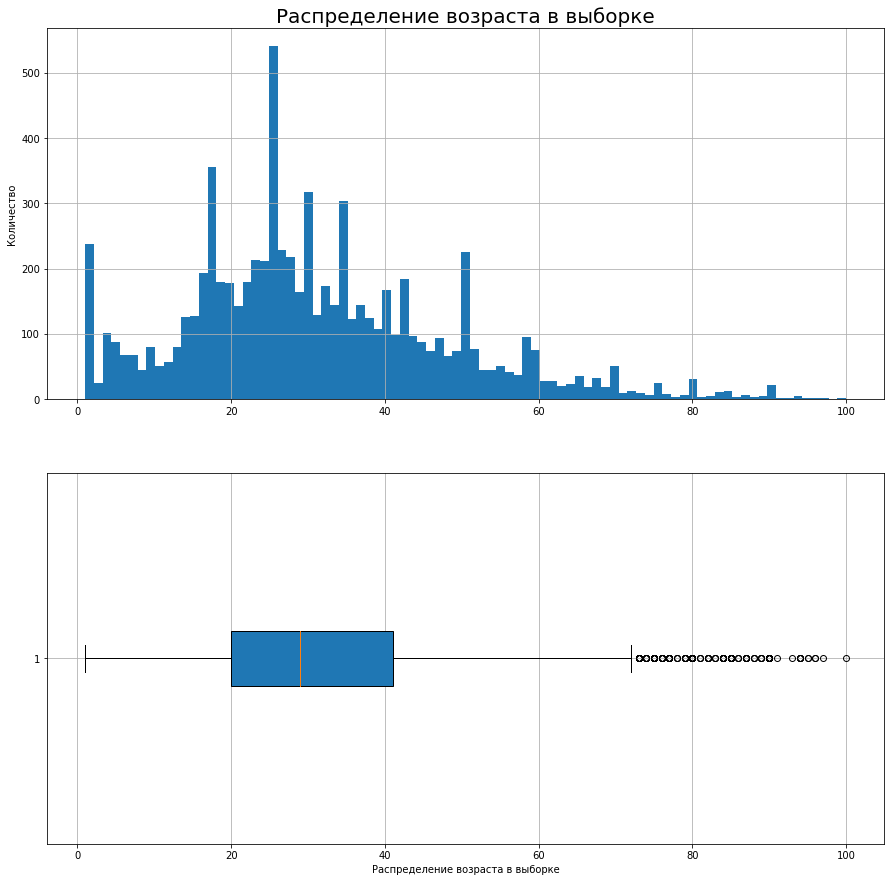

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [ ]:
sign(df_lab,'real_age', 'Распределение возраста в выборке')

In [ ]:
sign_a(df_lab, 'Распределение возраста в выборке')

In [ ]:
def check(a,b):
    for i,k in zip(df_lab.file_name[a:b],df_lab.real_age[a:b]):
        image = Image.open('/datasets/faces/final_files/'+i)
        array = np.array(image)
        plt.title('Возраст {:.0f}'.format(k))
        plt.imshow(array)

        plt.show()

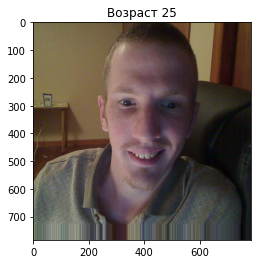

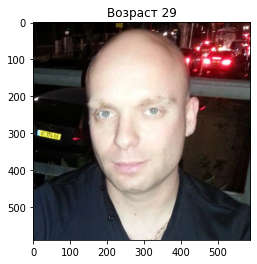

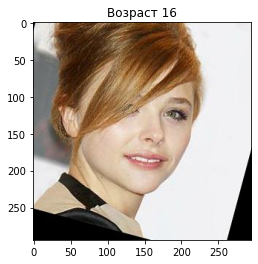

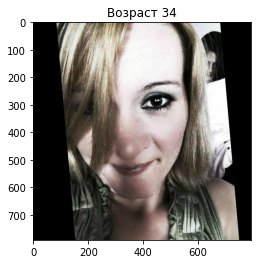

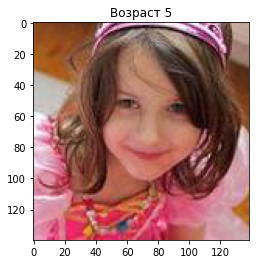

In [ ]:
check(700,705)

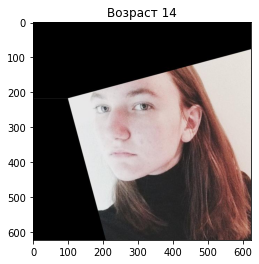

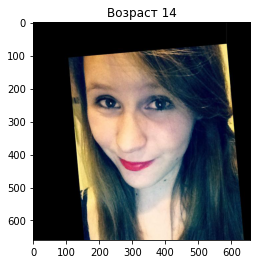

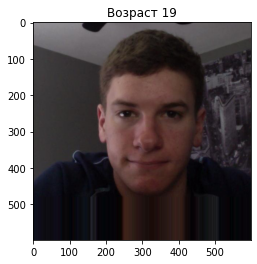

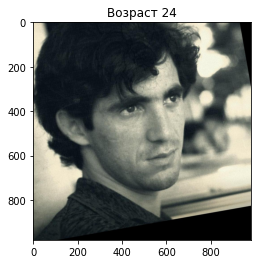

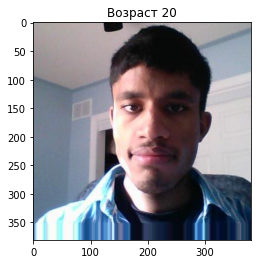

In [ ]:
check(2000,2005)

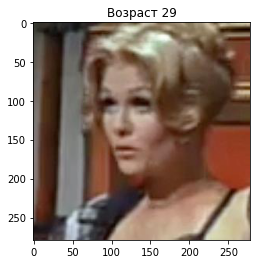

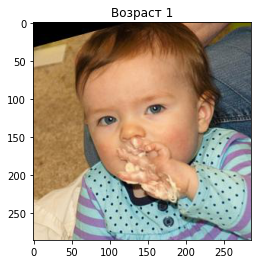

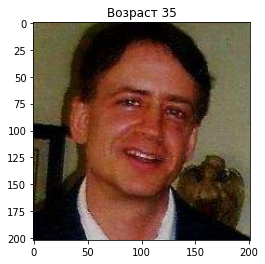

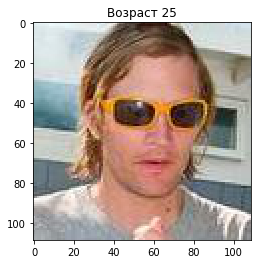

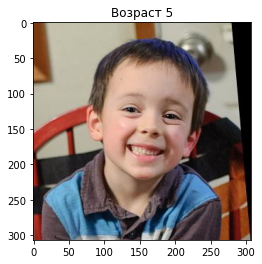

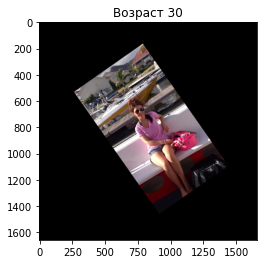

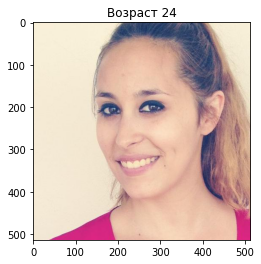

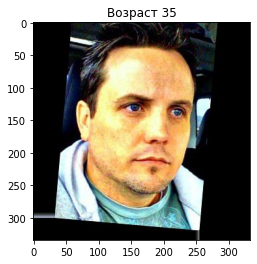

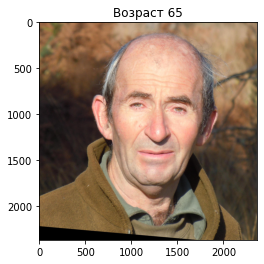

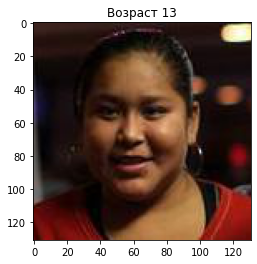

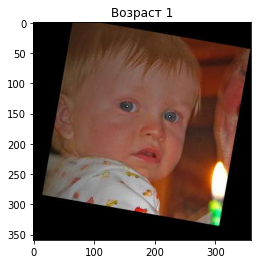

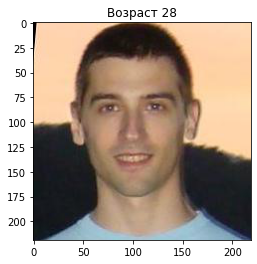

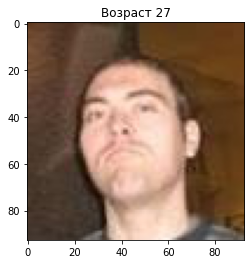

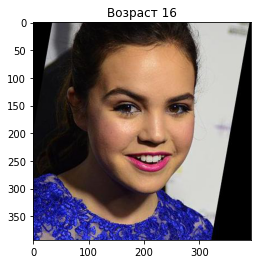

In [ ]:
check(20,34)

### Вывод

База данных APPA-REAL содержит 7591 изображение с соответствующими метками реального возраста.
Размеры изображений 224 на 224.

При анализе изображений наблюдается:

В базе присутствуют изображения с поворотом, разного уровня шума. Изображения находятся в разных цветовых гаммах, также присутствуют чёрно-белые.

При анализе возраста наблюдается:

- Наибольшее количество изображений людей в диапазоне от 20 до 40 лет.

- Пиковые значения в области юбилеев и первого года жизни.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python


optimizer = Adam()
def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255.)

    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_data

def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255.)

    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= '/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_data





def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Dense(1, activation='softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
Результат работы
```

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 72s - loss: 197.4420 - mae: 10.1764 - val_loss: 575.7363 - val_mae: 18.8227
Epoch 2/10
356/356 - 43s - loss: 83.8665 - mae: 6.9581 - val_loss: 132.4048 - val_mae: 8.8216
Epoch 3/10
356/356 - 43s - loss: 57.0042 - mae: 5.7373 - val_loss: 110.7271 - val_mae: 8.3095
Epoch 4/10
356/356 - 43s - loss: 43.2923 - mae: 5.0345 - val_loss: 73.5337 - val_mae: 6.5212
Epoch 5/10
356/356 - 43s - loss: 32.4820 - mae: 4.3413 - val_loss: 71.7547 - val_mae: 6.5353
Epoch 6/10
356/356 - 43s - loss: 24.1179 - mae: 3.7607 - val_loss: 76.0312 - val_mae: 6.4117
Epoch 7/10
356/356 - 43s - loss: 20.9615 - mae: 3.4642 - val_loss: 79.4009 - val_mae: 6.8076
Epoch 8/10
356/356 - 43s - loss: 19.0701 - mae: 3.3397 - val_loss: 65.5915 - val_mae: 6.0436
Epoch 9/10
Epoch 10/10
356/356 - 43s - loss: 15.4880 - mae: 2.9830 - val_loss: 76.9043 - val_mae: 6.4531
356/356 - 43s - loss: 13.5459 - mae: 2.8033 - val_loss: 67.5648 - val_mae: 6.1227



119/119 - 11s - loss: 67.5648 - mae: 6.1227
Test MAE: 6.1227

```

## Анализ обученной модели

Построена модель, определяющая по фотографии приблизительный возраст человека, с метрикой на тестовой выборке 6.1227.

При построении модели использована ResNet50 -CNN, которая имеет 50 основных слоев (сверточные и полносвязные).
На выходном слое модель имеет один нейрон. Для оптимизации использован алгоритм Adam- алгоритм адаптивной оптимизации, созданный специально для глубокого обучения нейронных сетей.